## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

## Load Data

**Define FASTA helper function**

In [4]:
import re

def load_fasta(file):
    with open(file, 'r', encoding='utf-8') as file:
        text = file.read()
    
    pattern = re.compile(r'>[A-Z]{2,3}_?\d+\.\d+')
    result = pattern.split(text)
    result = [element.replace('\n', '') for element in result]
    result = [element for element in result if element.strip()]
    return result

**Load virus datasets**

In [5]:
# Preprocess all fasta files
covid = load_fasta('covid_sequences.fasta')
dengue = load_fasta('dengue_sequences.fasta')
hepatitis = load_fasta('hepatitis_sequences.fasta')
influenza = load_fasta('influenza_sequences.fasta')
mers = load_fasta('mers_sequences.fasta')

In [6]:
# Create pandas dataframe
sequence_len_covid = [len(i) for i in covid]
sequence_len_dengue = [len(i) for i in dengue]
sequence_len_hepatitis = [len(i) for i in hepatitis]
sequence_len_influenza = [len(i) for i in influenza]
sequence_len_mers = [len(i) for i in mers]

df_covid = pd.DataFrame({"Sequence": covid, "Len": sequence_len_covid, "Label": 0})
df_dengue = pd.DataFrame({"Sequence": dengue, "Len": sequence_len_dengue, "Label": 1})
df_hepatitis = pd.DataFrame({"Sequence": hepatitis, "Len": sequence_len_hepatitis, "Label": 2})
df_influenza = pd.DataFrame({"Sequence": influenza, "Len": sequence_len_influenza, "Label": 3})
df_mers = pd.DataFrame({"Sequence": mers, "Len": sequence_len_mers, "Label": 4})

df = pd.concat([df_covid, df_dengue, df_hepatitis, df_influenza, df_mers], ignore_index=True)
display(df.head())

print(len(df_covid))
print(len(df_dengue))
print(len(df_hepatitis))
print(len(df_influenza))
print(len(df_mers))

,Sequence,Len,Label
0,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,29903,0
1,TAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTTGATC...,29796,0
2,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,29841,0
3,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTTGA...,29835,0
4,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTTGA...,29844,0


200
200
200
200
200


## Data Preprocessing

**Cleanse for any unwanted characters**

In [5]:
pattern = '[^ACGT]'

df['Sequence'] = df['Sequence'].apply(lambda x: re.sub(pattern, '', x))

**Encoding via K-mer counting**

In [6]:
# K-mer helper function
def get_Kmer(string, k):
    return [string[i:i+k].lower() for i in range(len(string) - k + 1)]

In [9]:
# K-mer size
k = 6

# Find K-mers for each sequence
df['Kmer'] = df.apply(lambda x: get_Kmer(x['Sequence'], k), axis=1)
df = df.reindex(columns=['Sequence', 'Len', 'Kmer', 'Label']).drop(['Sequence', 'Len'], axis=1)
display(df.head())

,Kmer,Label
0,"[attaaa, ttaaag, taaagg, aaaggt, aaggtt, aggtt...",0
1,"[taaagg, aaaggt, aaggtt, aggttt, ggttta, gttta...",0
2,"[attaaa, ttaaag, taaagg, aaaggt, aaggtt, aggtt...",0
3,"[attaaa, ttaaag, taaagg, aaaggt, aaggtt, aggtt...",0
4,"[attaaa, ttaaag, taaagg, aaaggt, aaggtt, aggtt...",0


**Label feature and target variable**

In [10]:
# Feature variables
X_kmers = list(df['Kmer'])
X_kmers = [' '.join(X_kmers[i]) for i in range(len(X_kmers))]

# Target variables
y = df.iloc[:, 1]

**Define n-grams function**

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(4,4))

**Get n-grams for each sequence**

In [12]:
X_kmer = cv.fit_transform(virus_kmers)
print(X_kmer.shape)

(1000, 197982)


## Multinomial Naive Bayes

In [16]:
# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_kmer, y, test_size=0.2, random_state=1)

# Instantiate classifier
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [17]:
# Prediction
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        33
           2       1.00      0.98      0.99        50
           3       0.98      1.00      0.99        40
           4       1.00      1.00      1.00        36

    accuracy                           0.99       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200



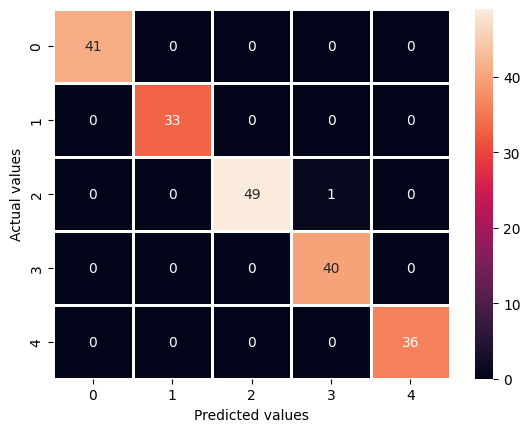

In [19]:
# Confusion matrix
cf_human = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_human, linewidths=1, annot=True, fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('Actual values');